In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses


torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.cuda.empty_cache()


from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [2]:
# More parameters / computing setup

# set the number of threads that pytorch will use
torch.set_num_threads(2)

exp_id = "dim_studies/1000d/"

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)

# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

#check if experiment alreadyexists
if os.path.isdir(expt_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(expt_dir)

print("experiment: "+str(exp_id) , flush=True)


device: cuda
ERROR: experiment already exists, don't want to overwrite it by mistake
experiment: dim_studies/1000d/


# Load in the processed data

In [3]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"


save_id_dir = "n_sig_6557_n_bkg_8000_n_nonzero_30_n_pad_20/"
grading = 30

path_to_data = path_to_save_dir+save_id_dir
print(path_to_data)



data_train = np.load(path_to_data+"data_train.npy")
labels_train = np.load(path_to_data+"labels_train.npy")
data_val = np.load(path_to_data+"data_val.npy")
labels_val = np.load(path_to_data+"labels_val.npy")
data_test_f = np.load(path_to_data+"data_test_f.npy")
labels_test_f = np.load(path_to_data+"labels_test_f.npy")

# print data dimensions
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

/global/home/users/rrmastandrea/training_data/n_sig_6557_n_bkg_8000_n_nonzero_30_n_pad_20/
BC training data shape: (10189, 3, 50)
BC training labels shape: (10189,)
BC val data shape: (2184, 3, 50)
BC val labels shape: (2184,)
BC test data shape: (2184, 3, 50)
BC test labels shape: (2184,)


# Run the transformer architecture as a BC

In [4]:
"""
Define the Binary Classifier transformer net
"""

# transformer hyperparams
input_dim = 3
model_dim = 1000
output_dim = model_dim
dim_feedforward = model_dim
n_heads = 4
n_layers = 2
n_head_layers = 2
opt = "adam"

mask= False
cmask = True

learning_rate_trans = 0.0001
batch_size = 256


netBC = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt, BC = True )

## send network to device
netBC.to( device )

# define lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( netBC.optimizer, factor=0.2 )


In [5]:
run_BC_transformer = True

criterion = nn.BCELoss()

n_constits_max = grading


if run_BC_transformer:

    # THE TRAINING LOOP

    # initialise lists for storing training stats, validation loss
    losses_BC_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    loss_validation_num_jets = {i:[[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, loss

    n_epochs = 20
    loss_check_epoch = 2
    verbal_epoch = 2

    for constit_num in range(grading,n_constits_max+grading,grading):

        t0 = time.time()

        print( "starting training loop, running for " + str( n_epochs ) + " epochs" + " with " + str(constit_num) + " constituents" 
              , flush=True)
        print("BC training data shape:",data_train.shape)
        print("BC val data shape:",data_val.shape)
        print( "---", flush=True )

        # re-batch the data on each epoch
        for epoch in range( n_epochs + 1 ):

            # get batch_size number of indices
            indices_list = torch.split( torch.randperm( data_train.shape[0] ), batch_size )

            # initialise lists to store batch stats
            losses_BC_e = []

            # the inner loop goes through the dataset batch by batch
            # augmentations of the jets are done on the fly
            for i, indices in enumerate( indices_list ): # random jets from the dataset
                netBC.optimizer.zero_grad()
                """
                DATA PREPARATION
                """
                x_i = data_train[indices,:,:]
                labels_i = labels_train[indices]

                x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                labels_i = torch.Tensor( labels_i ).to( device )
                z_i = netBC( x_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)

                """
                LOSS CALCULATIONS
                """           

                # compute the loss based on predictions of the netBC and the correct answers
                loss = criterion( z_i, labels_i.reshape(-1,1)).to( device )
                loss.backward()
                netBC.optimizer.step()
                netBC.optimizer.zero_grad()
                
                losses_BC_e.append( loss.detach().cpu().numpy() )
                
            """
            AVERAGING OF LOSSES
            """ 
            loss_BC_e = np.mean( np.array( losses_BC_e ) )
            ## scheduler
            scheduler.step( loss_BC_e )

            # storage
            losses_BC_num_jets[constit_num].append( loss_BC_e )
           
            """
            EVERY SO OFTEN, GIVEN AN UPDATE
            """

            if epoch % verbal_epoch == 0:

                print( "epoch: " + str( epoch ) + ", loss: " + str( round(losses_BC_num_jets[constit_num][-1], 5) ), flush=True )
                print("time taken up to now: " + str(time.time()-t0))
                print()

            if epoch % loss_check_epoch == 0:

                """
                Get the validation loss
                """
                print("Getting the validation loss...")
                # store the epoch
                loss_validation_num_jets[constit_num][0].append(epoch)

                with torch.no_grad():
                    netBC.eval()

                    # get batch_size number of indices
                    indices_list_val = torch.split( torch.randperm( data_val.shape[0] ), batch_size )
                    local_val_losses = []

                    for j, indices_val in enumerate( indices_list_val ):
                        
                        """
                        DATA PREPARATION
                        """
                        a_i = data_val[indices_val,:,:]
                        labelsa_i = labels_val[indices_val]

                        a_i = torch.Tensor( a_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                        labelsa_i = torch.Tensor( labelsa_i ).to( device )
                        w_i = netBC( a_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)

                        """
                        LOSS CALCULATIONS
                        """           

                        # compute the loss based on predictions of the netBC and the correct answers
                        loss_val = criterion( w_i, labelsa_i.reshape(-1,1)).to( device )
                        local_val_losses.append(loss_val.detach().cpu().numpy())
                
                    loss_val_e = np.mean( np.array( local_val_losses ) )
                    loss_validation_num_jets[constit_num][1].append(loss_val_e)
     

        t1 = time.time()

        print( "BC TRAINING DONE, time taken: " + str( np.round( t1-t0, 2 ) ), flush=True)


        # save out results
        print( "saving out data/results", flush=True)
        np.save( expt_dir+"BC_losses_train_"+str(constit_num)+".npy", losses_BC_num_jets[constit_num] )
        np.save( expt_dir+"BC_losses_val_"+str(constit_num)+".npy", loss_validation_num_jets[constit_num] )

        # save out final trained model
        print( "saving out final BC model", flush=True )
        torch.save(netBC.state_dict(), expt_dir+"final_model_BC_"+str(constit_num)+".pt")
        print()
        



starting training loop, running for 20 epochs with 30 constituents
BC training data shape: (10189, 3, 50)
BC val data shape: (2184, 3, 50)
---
epoch: 0, loss: 0.76473
time taken up to now: 3.8126823902130127

Getting the validation loss...
epoch: 2, loss: 0.43845
time taken up to now: 11.46866512298584

Getting the validation loss...
epoch: 4, loss: 0.42196
time taken up to now: 19.160032987594604

Getting the validation loss...
epoch: 6, loss: 0.41138
time taken up to now: 26.87513518333435

Getting the validation loss...
epoch: 8, loss: 0.40969
time taken up to now: 34.610129833221436

Getting the validation loss...
epoch: 10, loss: 0.40403
time taken up to now: 42.37424898147583

Getting the validation loss...
epoch: 12, loss: 0.39612
time taken up to now: 50.14821434020996

Getting the validation loss...
epoch: 14, loss: 0.39617
time taken up to now: 57.93628478050232

Getting the validation loss...
epoch: 16, loss: 0.37606
time taken up to now: 65.71949768066406

Getting the valid

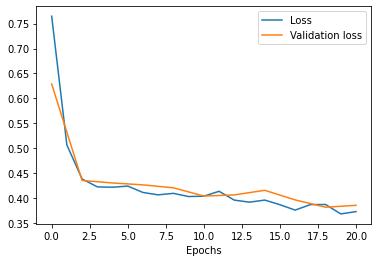

In [6]:

plot_list = [(range(n_epochs+1), losses_BC_num_jets[constit_num], "Loss"),
             (loss_validation_num_jets[constit_num][0], loss_validation_num_jets[constit_num][1], "Validation loss")]
plot_losses(plot_list, "")  


# Evaluate the final transformer classifier

In [7]:
# Loading in the final transformer

constit_num = grading
loaded_net_BC = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt, BC = True )

loaded_net_BC.load_state_dict(torch.load(expt_dir+"final_model_BC_"+str(constit_num)+".pt"))
loaded_net_BC.eval()

loaded_net_BC.to( device )


Transformer(
  (embedding): Linear(in_features=3, out_features=1000, bias=True)
  (decoder): Linear(in_features=1000, out_features=1, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_features=1000, bias=True)
        )
        (linear1): Linear(in_features=1000, out_features=1000, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1000, out_features=1000, bias=True)
        (norm1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_f

Evaluating...
BC data saved


/global/home/users/rrmastandrea/computingEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


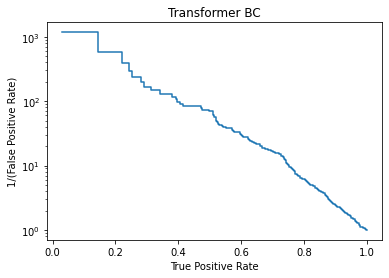

In [8]:
# Running the final transformer on the binary classification data

BC_fpt_tpr = {"fpr":[],"tpr":[]}


print("Evaluating...")
with torch.no_grad():    
    
    inputs = torch.Tensor( data_test_f ).transpose(1,2).to( device )
    

    outputs = loaded_net_BC( inputs, use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()
    predicted = np.round(outputs).reshape(labels_test_f.size)
    
    # calculate auc 
    auc = roc_auc_score(labels_test_f, outputs)

    fpr, tpr, _ = roc_curve(labels_test_f, outputs)

    total = labels_test_f.size
    correct = (predicted == labels_test_f).sum()    

    np.save( expt_dir+"trans_BC_fpr_"+str(constit_num)+".npy", fpr )
    np.save( expt_dir+"trans_BC_tpr_"+str(constit_num)+".npy", tpr )
        
        
print("BC data saved")

plt.figure()
plt.plot(tpr, 1.0/fpr)
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.title("Transformer BC")
plt.show()

